In [1]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext autotime

time: 105 µs (started: 2022-08-01 09:27:33 +00:00)


Divide and Concur 

In [3]:
from math import sqrt, floor
import numpy as np

def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.
    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

time: 45.9 ms (started: 2022-08-01 09:27:35 +00:00)


**Imports**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

time: 2.15 s (started: 2022-08-01 09:27:40 +00:00)


***Data Load***

In [5]:
df = pd.read_csv("https://github.com/sumit07041997/Thesis/blob/437361b5fcfd32e5c8bae4dd661f4daaf095d33c/Dry_Bean_Dataset.csv?raw=true")

time: 1.71 s (started: 2022-08-01 09:27:44 +00:00)


**Check for null values**

In [6]:
df.isnull().values.any()

False

time: 14.4 ms (started: 2022-08-01 09:27:50 +00:00)


**No. of Classes & its Count**

In [7]:
lable = df['Class'].copy()
data = df.drop('Class',axis=1)
lable.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

time: 23.8 ms (started: 2022-08-01 09:27:53 +00:00)


**Scaling**

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data= scaler.fit_transform(data)

time: 14.2 ms (started: 2022-08-01 09:27:55 +00:00)


**Elbow Method**

1. Using Distortion 
- Computes the sum of squared distances from each point to its assigned center.

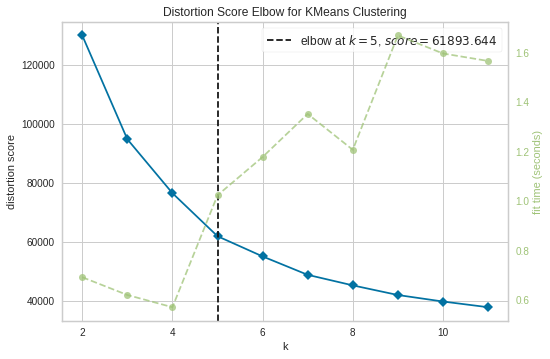

time: 12.3 s (started: 2022-08-01 09:27:59 +00:00)


In [9]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='distortion'
)
visualizer.fit(data)        
visualizer.show() 

2. Silhouette score 
- calculates the mean Silhouette Coefficient of all samples

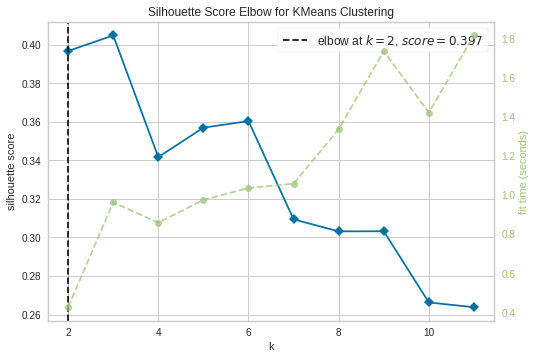

time: 38.8 s (started: 2022-08-01 09:28:16 +00:00)


In [10]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette'
)
visualizer.fit(data)        
visualizer.show() 

3. Calinski_harabasz score 
- computes the ratio of dispersion between and within clusters.

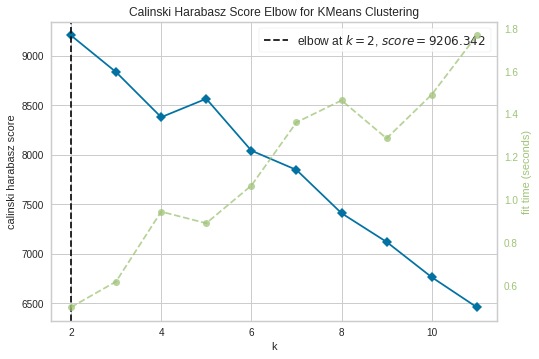

time: 11.8 s (started: 2022-08-01 09:29:27 +00:00)


In [11]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz'
)
visualizer.fit(data)        
visualizer.show() 

In [12]:
kmeans = KMeans(n_clusters=7,init='random', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  15
time: 453 ms (started: 2022-08-01 09:29:51 +00:00)


In [13]:
kmeans = KMeans(n_clusters=7,init='k-means++', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  14
time: 1.48 s (started: 2022-08-01 09:29:55 +00:00)


In [15]:
kmeans = KMeans(n_clusters=7,init=naive_sharding(data,7), random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Iterations:  42
time: 315 ms (started: 2022-08-01 09:30:15 +00:00)


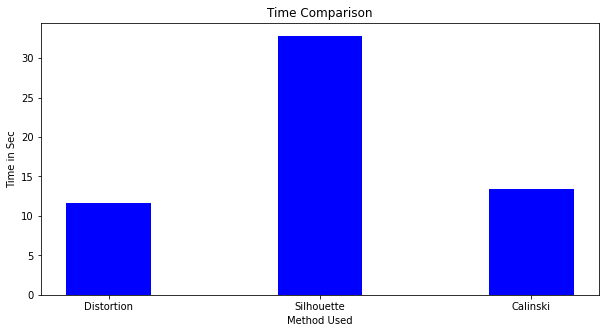

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 

method = ['Distortion','Silhouette','Calinski']
time = [11.6,32.8,13.4]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, time, color ='blue',
        width = 0.4)
 
plt.xlabel("Method Used")
plt.ylabel("Time in Sec")
plt.title("Time Comparison")
plt.show()